In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime , timedelta
import getpass
import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas

In [2]:
# Set seaborn style for better visuals
sns.set(style = "whitegrid")

In [3]:
pw = getpass.getpass("Your Snowflake Password: \n")

Your Snowflake Password: 
 ········


In [4]:
# Connect to Snowflake
try:
    conn = snowflake.connector.connect(
        user = "gauravgm14",
        password = pw,
        account = 'phytzbh-gl41994',
        warehouse = 'gaurav',
        database = 'retail_project',
        schema = 'public'
    )
except snowflake.connector.errors.Error as e:
    print(f"Error connecting to snowflake: {e}")
    raise


In [5]:
# Function for fetching data from Snowwflake
def fetch_data(query):
    cur = conn.cursor()
    cur.execute(query)
    df = cur.fetch_pandas_all()
    cur.close()
    return df

In [6]:
queries = {
    "CAMPAIGN_DESC_RAW": " select * from CAMPAIGN_DESC_RAW ;",
    "CAMPAIGN_RAW": " select * from CAMPAIGN_RAW ;",
    "COUPON_RAW": " select * from COUPON_RAW ;",
    "COUPON_REDEMPT_RAW": " select * from COUPON_REDEMPT_RAW ;",
    "HH_DEMOGRAPHIC_RAW": " select * from HH_DEMOGRAPHIC_RAW ;",
    "PRODUCT_RAW": " select * from PRODUCT_RAW ;",
    "TRANSACTIONS_RAW": " select * from TRANSACTIONS_RAW ;"
}

In [7]:
# Load all data into respective dataframes

data = {name:fetch_data(query) for name, query in queries.items()}

In [8]:
# Data Overview and initial EDA
for name, df in data.items():
    print(f"{name} shape:{df.shape}")
    print(f"Missing values in {name}:")
    print(df.isnull().sum())

CAMPAIGN_DESC_RAW shape:(30, 4)
Missing values in CAMPAIGN_DESC_RAW:
DESCRIPTION    0
CAMPAIGN       0
START_DAY      0
END_DAY        0
dtype: int64
CAMPAIGN_RAW shape:(7208, 3)
Missing values in CAMPAIGN_RAW:
DESCRIPTION      0
HOUSEHOLD_KEY    0
CAMPAIGN         0
dtype: int64
COUPON_RAW shape:(124548, 3)
Missing values in COUPON_RAW:
COUPON_UPC    0
PRODUCT_ID    0
CAMPAIGN      0
dtype: int64
COUPON_REDEMPT_RAW shape:(2318, 4)
Missing values in COUPON_REDEMPT_RAW:
HOUSEHOLD_KEY    0
DAY              0
COUPON_UPC       0
CAMPAIGN         0
dtype: int64
HH_DEMOGRAPHIC_RAW shape:(2500, 8)
Missing values in HH_DEMOGRAPHIC_RAW:
AGE_DESC               0
MARITAL_STATUS_CODE    0
INCOME_DESC            0
HOMEOWNER_DESC         0
HH_COMP_DESC           0
HOUSEHOLD_SIZE_DESC    0
KID_CATEGORY_DESC      0
HOUSEHOLD_KEY          0
dtype: int64
PRODUCT_RAW shape:(92353, 7)
Missing values in PRODUCT_RAW:
PRODUCT_ID              0
MANUFACTURER            0
DEPARTMENT              0
BRAND        

In [10]:
# Transaction data transformation

start_date = pd.to_datetime('2020-01-01')
data['TRANSACTIONS_RAW']['DATE'] = start_date + pd.to_timedelta(data['TRANSACTIONS_RAW']['DAY'], unit='D')

In [11]:
# Campaign data transformation

data['CAMPAIGN_DESC_RAW']['START_DATE'] = start_date + pd.to_timedelta(data['CAMPAIGN_DESC_RAW']['START_DAY'], 'D')
data['CAMPAIGN_DESC_RAW']['END_DATE'] = start_date + pd.to_timedelta(data['CAMPAIGN_DESC_RAW']['END_DAY'], 'D')
data['CAMPAIGN_DESC_RAW']['CAMPAIGN_DURATION'] = data['CAMPAIGN_DESC_RAW']['END_DAY'] - data['CAMPAIGN_DESC_RAW']['START_DAY']

In [12]:
# Coupon redemption data transformation

data['COUPON_REDEMPT_RAW']['DATE'] = start_date + pd.to_timedelta(data['COUPON_REDEMPT_RAW']['DAY'],'D')

### Campaign Duration Analysis

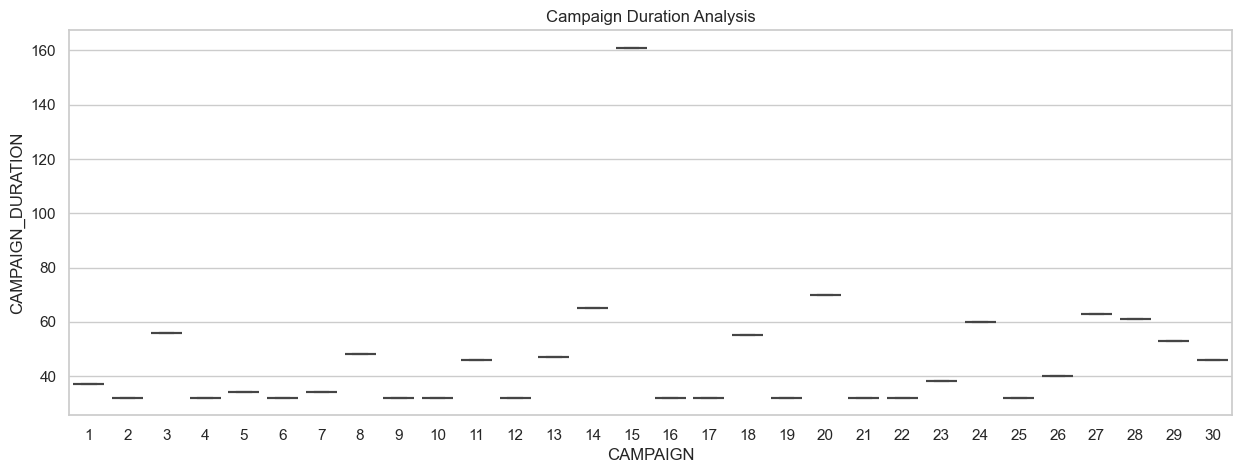

In [13]:
plt.figure(figsize=(15,5))
sns.boxplot(x='CAMPAIGN', y='CAMPAIGN_DURATION', data = data['CAMPAIGN_DESC_RAW'])
plt.title("Campaign Duration Analysis")
plt.show()

In [14]:
campaign_agg = data['CAMPAIGN_DESC_RAW'].groupby('DESCRIPTION').aggregate({'CAMPAIGN':'count', 'CAMPAIGN_DURATION':'mean'})
print(campaign_agg)

             CAMPAIGN  CAMPAIGN_DURATION
DESCRIPTION                             
TypeA               5          47.200000
TypeB              19          37.631579
TypeC               6          74.500000


In [15]:
# Household participation analysis

unique_household_campaigns = data['CAMPAIGN_RAW']['HOUSEHOLD_KEY'].nunique()
unique_household_total = data['HH_DEMOGRAPHIC_RAW']['HOUSEHOLD_KEY'].nunique()
non_participating_household = unique_household_total - unique_household_campaigns
print(f"Unique households in campaigns: {unique_household_campaigns}")
print(f"Non-participating households: {non_participating_household}")

Unique households in campaigns: 1584
Non-participating households: 916


In [16]:
# Coupon analysis

coupon_given = data['COUPON_RAW'].groupby('CAMPAIGN').aggregate(
    Total_products = ('PRODUCT_ID','nunique'),
    Total_coupons_given = ('COUPON_UPC','nunique'))
coupon_given = coupon_given.merge(data['CAMPAIGN_DESC_RAW'] , how='left' , on='CAMPAIGN')
print(coupon_given.loc[:,['CAMPAIGN','Total_products','Total_coupons_given','START_DATE','END_DATE']])

    CAMPAIGN  Total_products  Total_coupons_given START_DATE   END_DATE
0          1             383                   11 2020-12-12 2021-01-18
1          2             301                   16 2020-12-17 2021-01-18
2          3             506                   34 2020-12-22 2021-02-16
3          4             200                   12 2021-01-07 2021-02-08
4          5             443                   11 2021-01-12 2021-02-15
5          6              18                    1 2021-01-28 2021-03-01
6          7             259                    8 2021-02-02 2021-03-08
7          8           17178                  209 2021-02-16 2021-04-05
8          9             825                   18 2021-03-11 2021-04-12
9         10             393                   14 2021-04-08 2021-05-10
10        11             278                   13 2021-04-22 2021-06-07
11        12             620                   15 2021-04-22 2021-05-24
12        13           35616                  207 2021-05-19 202

In [17]:
# Product-level coupon analysis

coupon_product = data['COUPON_RAW'].merge(data['PRODUCT_RAW'], on='PRODUCT_ID', how='left')
print(coupon_product['COMMODITY_DESC'].value_counts().sort_values(ascending=False).head(20))

COMMODITY_DESC
HAIR CARE PRODUCTS           6261
MAKEUP AND TREATMENT         5585
FRZN MEAT/MEAT DINNERS       4893
FROZEN PIZZA                 3658
BEEF                         3314
ICE CREAM/MILK/SHERBTS       3257
CHEESE                       3146
YOGURT                       2460
ORAL HYGIENE PRODUCTS        2437
LUNCHMEAT                    2425
FRZN VEGETABLE/VEG DSH       2051
BABY FOODS                   2038
HAND/BODY/FACIAL PRODUCTS    1984
VITAMINS                     1880
REFRGRATD JUICES/DRNKS       1856
SOAP - LIQUID & BAR          1791
PORK                         1783
SEAFOOD - FROZEN             1705
FLUID MILK PRODUCTS          1680
DEODORANTS                   1666
Name: count, dtype: int64


In [18]:
# Coupon redemption analysis

coupon_redeem = data['COUPON_REDEMPT_RAW'].groupby('CAMPAIGN').aggregate(total_coupon_redemt = ('COUPON_UPC','nunique'))
coupon_redeem = coupon_redeem.merge(coupon_given, how='left',on='CAMPAIGN')
coupon_redeem['Coupon_redeem_rate'] = (coupon_redeem['total_coupon_redemt']/coupon_redeem['Total_coupons_given'])*100
print(coupon_redeem.loc[:,['CAMPAIGN','Total_coupons_given','total_coupon_redemt','Coupon_redeem_rate']])

    CAMPAIGN  Total_coupons_given  total_coupon_redemt  Coupon_redeem_rate
0          1                   11                    1            9.090909
1          2                   16                    4           25.000000
2          3                   34                    2            5.882353
3          4                   12                    6           50.000000
4          5                   11                    5           45.454545
5          6                    1                    1          100.000000
6          7                    8                    5           62.500000
7          8                  209                  105           50.239234
8          9                   18                   14           77.777778
9         10                   14                    7           50.000000
10        11                   13                    6           46.153846
11        12                   15                   11           73.333333
12        13             

In [20]:
print(coupon_redeem.columns)

Index(['CAMPAIGN', 'total_coupon_redemt', 'Total_products',
       'Total_coupons_given', 'DESCRIPTION', 'START_DAY', 'END_DAY',
       'START_DATE', 'END_DATE', 'CAMPAIGN_DURATION', 'Coupon_redeem_rate'],
      dtype='object')


In [22]:
print(data['CAMPAIGN_DESC_RAW'].columns)

Index(['DESCRIPTION', 'CAMPAIGN', 'START_DAY', 'END_DAY', 'START_DATE',
       'END_DATE', 'CAMPAIGN_DURATION'],
      dtype='object')


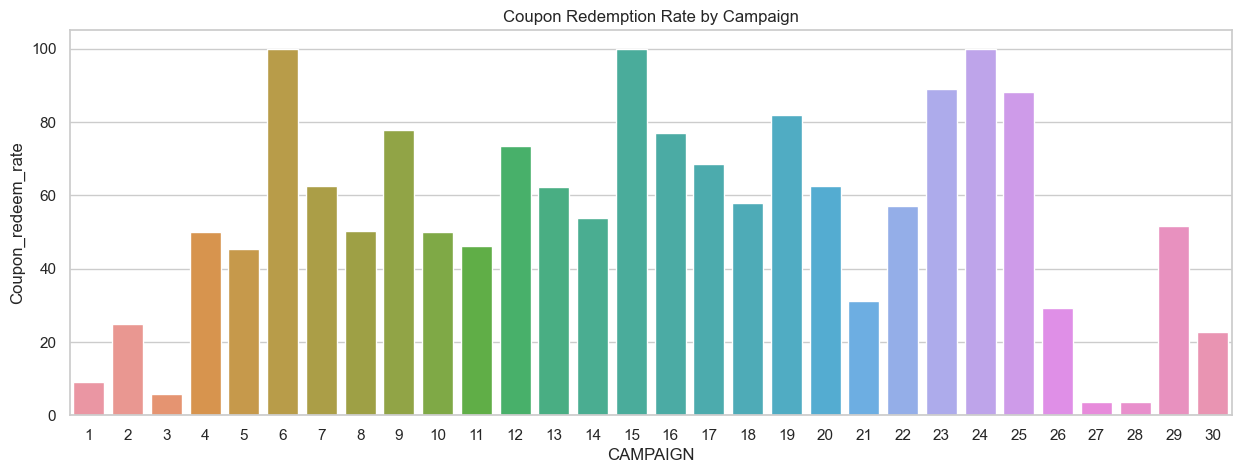

In [18]:
plt.figure(figsize=(15,5))
sns.barplot(x='CAMPAIGN',y='Coupon_redeem_rate' , data=coupon_redeem)
plt.title("Coupon Redemption Rate by Campaign")
plt.show()

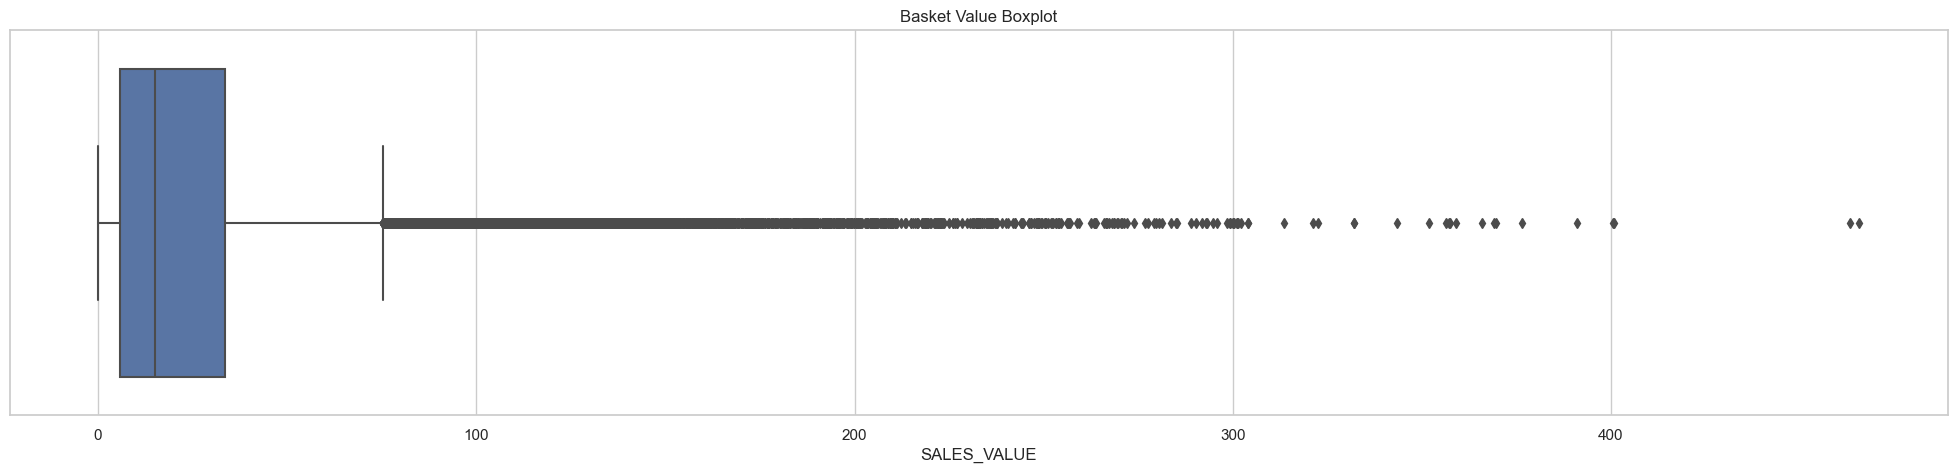

In [19]:
# Transaction Basket Analysis

tranx_bucket = data['TRANSACTIONS_RAW'].groupby('BASKET_ID').aggregate({
    'SALES_VALUE': 'sum',
    'COUPON_DISC': 'sum',
    'COUPON_MATCH_DISC': 'sum'
})
tranx_bucket['use_coupon'] = tranx_bucket['COUPON_DISC'] != 0

plt.figure(figsize=(25, 5))
sns.boxplot(x=tranx_bucket['SALES_VALUE'])
plt.title("Basket Value Boxplot")
plt.show()

In [21]:
# Basket analysis based on coupon usage
basket_analysis = tranx_bucket.groupby('use_coupon').aggregate(
    sales_value_mean=('SALES_VALUE', 'mean'),
    coupon_disc_mean=('COUPON_DISC', 'mean'),
    coupon_match_disc=('COUPON_MATCH_DISC', 'mean'),
    no_coupon=('SALES_VALUE', 'count')
)
print(basket_analysis)

            sales_value_mean  coupon_disc_mean  coupon_match_disc  no_coupon
use_coupon                                                                  
False              25.009980          0.000000           0.000000      47892
True               62.533348         -2.587167          -0.334364       2587


In [22]:
# Product-level analysis with transactions and coupon usage
tranx_desc = data['TRANSACTIONS_RAW'].merge(tranx_bucket, on='BASKET_ID', how='left')
tranx_desc = tranx_desc.merge(data['PRODUCT_RAW'], on='PRODUCT_ID', how='left')

commodity_coupon = tranx_desc.groupby('COMMODITY_DESC').aggregate(
    total_quantity=('QUANTITY', 'sum'),
    use_coupon=('use_coupon', 'sum'),
    coupon=('COUPON_DISC_x', 'sum')
)
commodity_coupon['coupon%'] = round((commodity_coupon['use_coupon'] / commodity_coupon['total_quantity']) * 100, 2)
print(commodity_coupon.sort_values('coupon%', ascending=False).head(20))

                         total_quantity  use_coupon  coupon  coupon%
COMMODITY_DESC                                                      
                                      0         872   -1396      inf
NATURAL VITAMINS                      2           1      -5    50.00
VALENTINE                             6           2       0    33.33
DIAPERS & DISPOSABLES               922         231    -215    25.05
RW FRESH PROCESSED MEAT               8           2       0    25.00
BABY HBC                            887         181     -82    20.41
BABY FOODS                         5787        1114     -38    19.25
LAUNDRY ADDITIVES                   948         176     -25    18.57
CAT LITTER                          587         104     -11    17.72
FRZN BREAKFAST FOODS               2073         347     -61    16.74
AIR CARE                           1154         193    -124    16.72
HOUSEHOLD CLEANG NEEDS             2166         355     -96    16.39
HAIR CARE PRODUCTS                

In [23]:
# Sales trends by year
sales_trends = data['TRANSACTIONS_RAW'].groupby(data['TRANSACTIONS_RAW']['DATE'].dt.year).aggregate({
    'SALES_VALUE': 'sum',
    'RETAIL_DISC': 'sum',
    'COUPON_DISC': 'sum'
})
print(sales_trends)

      SALES_VALUE  RETAIL_DISC  COUPON_DISC
DATE                                       
2020   1359551.73   -248978.11        -6693


In [24]:
# Dropping unnecessary columns and transforming date columns for database loading
data['CAMPAIGN_DESC_RAW'].drop(['START_DAY', 'END_DAY'], axis=1, inplace=True)
data['CAMPAIGN_DESC_RAW']['START_DATE'] = pd.to_datetime(data['CAMPAIGN_DESC_RAW']['START_DATE']).apply(lambda x: x.date())
data['CAMPAIGN_DESC_RAW']['END_DATE'] = pd.to_datetime(data['CAMPAIGN_DESC_RAW']['END_DATE']).apply(lambda x: x.date())

data['COUPON_REDEMPT_RAW'].drop(['DAY'], axis=1, inplace=True)
data['COUPON_REDEMPT_RAW']['DATE'] = pd.to_datetime(data['COUPON_REDEMPT_RAW']['DATE']).apply(lambda x: x.date())

data['TRANSACTIONS_RAW'].drop(['DAY', 'WEEK_NO'], axis=1, inplace=True)
data['TRANSACTIONS_RAW']['DATE'] = pd.to_datetime(data['TRANSACTIONS_RAW']['DATE']).apply(lambda x: x.date())

In [25]:
# Function to load data back to Snowflake
def load_to_snowflake(df, table_name):
    success, nchunks, nrows, _ = write_pandas(conn, df, table_name, quote_identifiers=False)
    print(f"Table {table_name} loaded successfully: {success}, Rows: {nrows}")

In [26]:
# Loading transformed data into Snowflake
load_to_snowflake(data['CAMPAIGN_DESC_RAW'], 'CAMPAIGN_DESC_NEW')
load_to_snowflake(data['COUPON_REDEMPT_RAW'], 'COUPON_REDEMPT_NEW')
load_to_snowflake(data['TRANSACTIONS_RAW'], 'TRANSACTIONS_NEW')

Table CAMPAIGN_DESC_NEW loaded successfully: True, Rows: 30
Table COUPON_REDEMPT_NEW loaded successfully: True, Rows: 2318
Table TRANSACTIONS_NEW loaded successfully: True, Rows: 450416


In [27]:
# Close the Snowflake connection
conn.close()